In [1]:
pip install tensorflow tensorflow-hub


You should consider upgrading via the '/Users/adam/.pyenv/versions/3.9.13/envs/hack4law/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import tensorflow_hub as hub

# Load the Universal Sentence Encoder
use_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
embed = hub.load(use_url)

2024-01-22 12:27:11.550423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-22 12:27:18.939599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import pickle

In [4]:
with open('sourceing_abstracts/papers.pkl', 'rb') as pickle_file:
    papers = pickle.load(pickle_file)


In [5]:
for paper in papers:
    paper['emb'] = embed([paper['summary']])[0].numpy().tolist()

In [6]:
import umap
import matplotlib.pyplot as plt

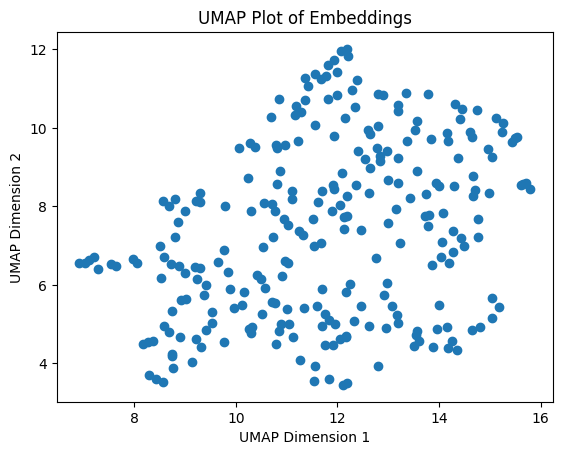

In [7]:
embeddings = [d["emb"] for d in papers]

# Create UMAP model and fit_transform the embeddings
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2)
umap_embeddings = umap_model.fit_transform(embeddings)

# Plot the UMAP embeddings
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1])
plt.title("UMAP Plot of Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

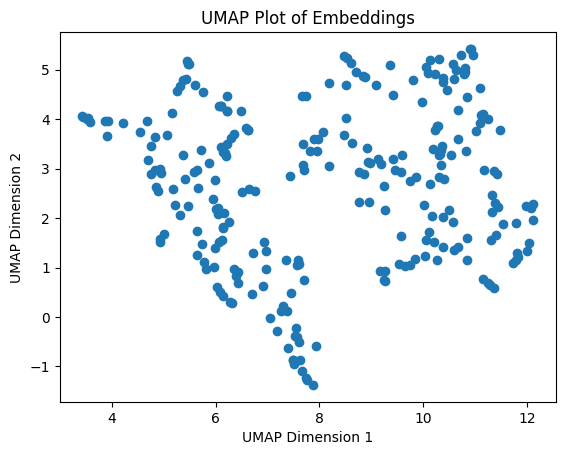

In [8]:
embeddings = [d["emb"] for d in papers]

# Create UMAP model and fit_transform the embeddings
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.1, n_components=2)
umap_embeddings = umap_model.fit_transform(embeddings)

# Plot the UMAP embeddings
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1])
plt.title("UMAP Plot of Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

In [10]:
with open('papers_emb_use5.pkl', 'wb') as pickle_file:
    pickle.dump(papers, pickle_file)

In [11]:
pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 6.7 MB/s eta 0:00:00m eta 0:00:010:01:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-py2.py3-none-any.whl (989 kB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp39-cp39-macosx_12_0_x86_64.whl size=712930 sha256=d15af2a9314735bfdcc1ef23548725fc38a966a43271b03f2435133eef372b7e
  Stored in directory: /Users/adam/Library/Caches/pip/wheels/28/5e/ed/5989da4cc423a222a47cbb4fde5d6c0eff4590d922e45f233c
Successfully built hdbscan
You should consider upgrading via the '/Users/adam/.pyenv/versions/3.9.13/envs/hack4law/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [12]:
import hdbscan

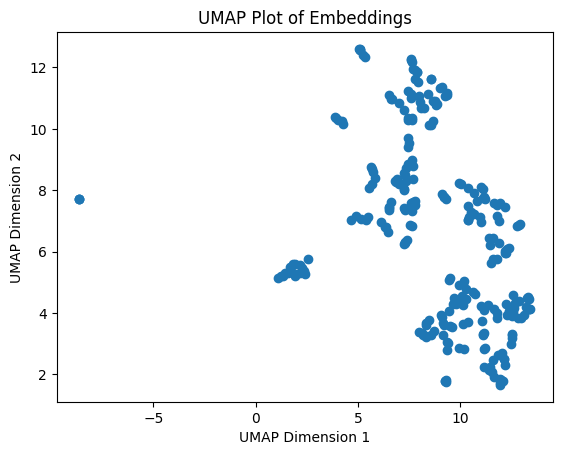

NameError: name 'get_cmap' is not defined

In [16]:
# Create UMAP model and fit_transform the embeddings
umap_model = umap.UMAP(n_neighbors=3, min_dist=0.1, n_components=2)
umap_embeddings = umap_model.fit_transform(embeddings)

# Plot the UMAP embeddings
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1])
plt.title("UMAP Plot of Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

min_cluster_size = 5  # Adjust the minimum cluster size based on your data
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
cluster_labels = clusterer.fit_predict(umap_embeddings)

# Get the number of unique clusters
num_clusters = len(set(cluster_labels))

from matplotlib.cm import get_cmap
from matplotlib.colors import to_rgba

# Create a variable-length colormap
cmap = get_cmap('tab10', num_clusters)

# Plot the UMAP embeddings with cluster information
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=cluster_labels, cmap=cmap)
plt.title("UMAP Plot with HDBSCAN Clusters")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")

# Add legend dynamically
legend_labels = list(set(cluster_labels))
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(to_rgba(label)), markersize=10) for label in legend_labels]
plt.legend(legend_handles, [f'Cluster {label}' for label in legend_labels], title="Clusters", loc="upper right")


plt.show()